# ハミルトニアンモンテカルロ法の実装
## 分布の形は分かっているが、分布から乱数を取得するのが難しいときに有効な手法

In [64]:
#= パッケージのインストールがまだなら必要
using Pkg
Pkg.add("Interact")
Pkg.add("Distributions")
Pkg.add("Plots")
Pkg.add("LinearAlgebra")
Pkg.add("ForwardDiff")
=#
#使用するパッケージ一覧
using Distributions #乱数にまつわる
using Plots #グラフの描画
using LinearAlgebra #ノルム関数に必要
using Interact #パラメータを動かしながらグラフを見られる
using ForwardDiff #自動微分の計算

# Leapfrog積分の実装
## ハミルトニアンを保存しながら時間発展をする


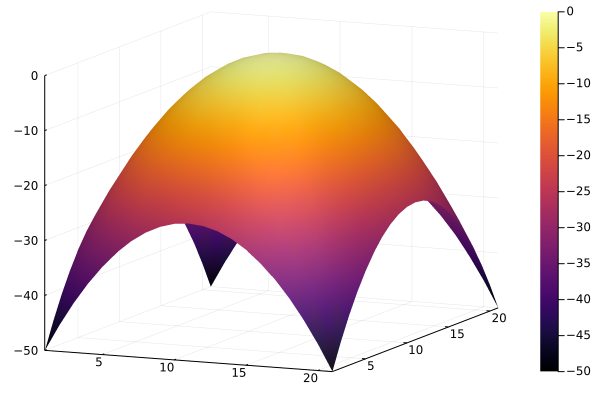

In [171]:
#θは多次元位置変数、ポテンシャルエネルギーを定義
U(θ)= norm(θ)^2
#pは多次元運動量変数、運動エネルギーを定義
K(p) = norm(p)^2 /2
#ハミルトニアンを定義
H(θ,p)=U(θ)+K(p)

#2変数の場合の目標の分布関数の形状を描画
A = [ -(x^2+y^2) for x in -5.0:0.5:5.0, y in -5.0:0.5:5.0]
surface(A)


┌ Info: Saved animation to 
│   fn = C:\Users\kamioka\tmp.gif
└ @ Plots C:\Users\kamioka\.julia\packages\Plots\qbc7U\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\kamioka\\tmp.gif")
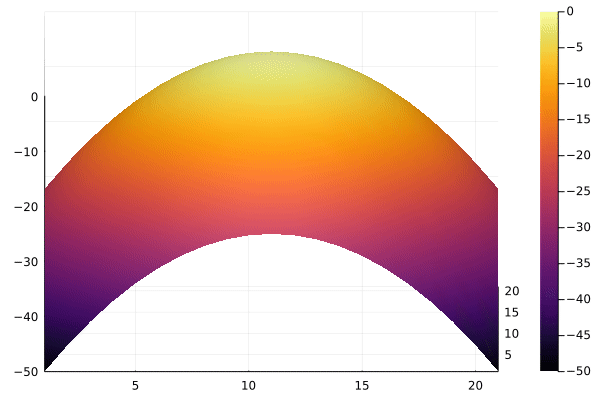

In [170]:
#グラフを動かしながら見てみる
@gif for θ in 0:2:90 
    surface(A,camera=(θ,30))
end

In [98]:
#leapfrog法を実装
#=
iter:反復回数
rate:刻み幅
θ_initial:位置の初期値
p_initial:運動量の初期値
=#
function leapfrog_integrator(iter,rate,θ_initial,p_initial)
    
    #位置と運動量の履歴をそれぞれ用意
    p_his = [p_initial]
    θ_his = [θ_initial]
    
    #=
    Leapfrog法の本質、運動量を二回更新しているのが特徴
    ForwardDiff.gradient(f,x)は∇f(x)を計算してくれる
    =#
    for i in 1:iter
        p_mid = (rate/2)*ForwardDiff.gradient(U,θ_his[i]) + p_his[i]
        θ_end = -rate*ForwardDiff.gradient(K,p_mid) + θ_his[i]
        p_end = (rate/2)*ForwardDiff.gradient(U,θ_end) + p_mid
        push!(p_his,p_end)
        push!(θ_his,θ_end)
    end
    
    return [θ_his,p_his]
end

leapfrog_integrator (generic function with 1 method)

In [77]:
#euler法を実装
#=
iter:反復回数
rate:刻み幅
θ_initial:位置の初期値
p_initial:運動量の初期値
=#
function euler_integrator(iter,rate,θ_initial,p_initial)
    
    #位置と運動量の履歴をそれぞれ用意
    p_his = [p_initial]
    θ_his = [θ_initial]
    
    #euler法は計算回数を減らす反面、Hを保存できないことがある。
    for i in 1:iter
        p_end = rate*ForwardDiff.gradient(U,θ_his[i]) + p_his[i]
        θ_end = -rate*ForwardDiff.gradient(K,p_end) + θ_his[i]
        push!(p_his,p_end)
        push!(θ_his,θ_end)
    end
    
    return [θ_his,p_his]
end

euler_integrator (generic function with 1 method)

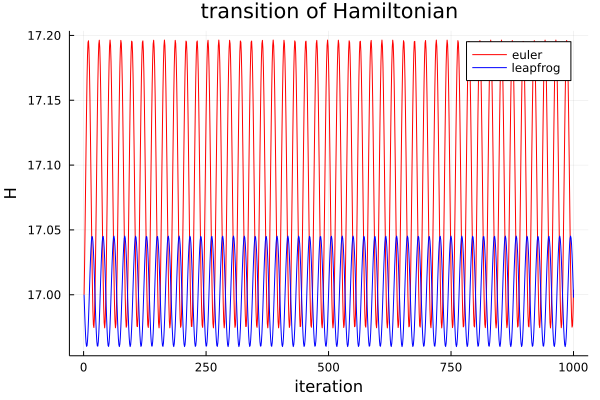

In [153]:
#性能の比較
num_sq=[i for i in 1:1:1000]
e_result=euler_integrator(1000,0.1,[2.0,2.0])
eH_sq=[H(e_result[1][i],e_result[2][i]) for i in 1:1000]

plt=plot(num_sq,eH_sq,lc=:red,label="euler")

result=leapfrog(1000,0.1,[2.0,2.0])
H_sq=[H(result[1][i],result[2][i]) for i in 1:1000]

plot!(plt,num_sq,H_sq,lc=:blue,label="leapfrog",
    xlabel="iteration",ylabel="H",title="transition of Hamiltonian"
)

# あまり違いがないようだが。。。
おそらく単純な関数だとあまり変化がない？

# いざ、HMCを実装
HMCはUの符号反転にexpを噛ませたものを正規化した関数を目標分布（＝乱数が欲しい！分布）としている。

やっていることのイメージとしては、摩擦のない曲面U上におはじきを置いて、ランダムにはじきながら、位置の履歴をとっている。

In [117]:
#ハミルトニアンモンテカルロ法の実装
#=
burn_in:焼き入れ期間
sampling:サンプリング回数
iter:leapfrog法の反復回数
rate:leapfrog法の刻み幅
θ_initial:位置の初期値
=#

function HMC(burn_in,sampling,iter,rate,θ_initial)
    
    θ=θ_initial
    #獲得したサンプルの履歴と、受容回数を用意
    θ_his=[θ_initial]
    accept_num=0
    
    #焼き入れ期間でのサンプリング部分
    for _ in 1:burn_in
        θ=get_sample(iter,rate,θ)
    end
    
    #実際にサンプリングを行う部分
    for i in 1:sampling
        θ=get_sample(iter,rate,θ)
        push!(θ_his,θ)
        
        #直前に獲得したサンプルと値が異なれば、受容されたサンプルと判断し受容回数を1足す
        if θ_his[i] !=θ
            accept_num +=1
        end
    end
    return [θ_his,accept_num]
end

#leapfrog法を実行し、サンプルを受容・棄却するまでの関数
#=
iter:反復回数
rate:刻み幅
θ_initial:最新の位置
=#
function get_sample(iter,rate,θ_initial)
    
    #運動量は平均0、共分散行列がIの多次元正規標準分布からランダムに取得
    p=[rand(Normal(0.0,1.0)),rand(Normal(0.0,1.0))]
    
    #leapfrog法を実行
    res=leapfrog_integrator(iter,rate,θ_initial,p)
    
    #更新前と更新後のハミルトニアンを計算し、受容確率αを計算
    H_old=H(θ_initial,p)
    H_new=H(res[1][end],res[2][end])
    α=exp(H_old - H_new)
    
    if rand() < α
        return res[1][end] #受容：更新後の位置を返す
    else
        return θ_initial　#棄却:更新前の位置を返す
    end
end 

get_sample (generic function with 1 method)

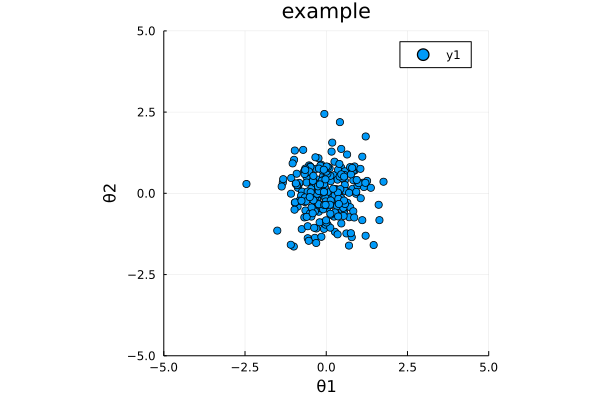

In [143]:
#サンプルを載せてみる
test=HMC(100,1000,10,0.1,[2.0,2.0])
example=scatter([(test[1][i][1],test[1][i][2]) for i in 751:1000],
xlims=(-5.0,5.0),ylims=(-5.0,5.0),aspect_ratio=1.0,
xlabel="θ1",ylabel="θ2",title="example")

# いい感じ

# 少し複雑な形状にチャレンジ

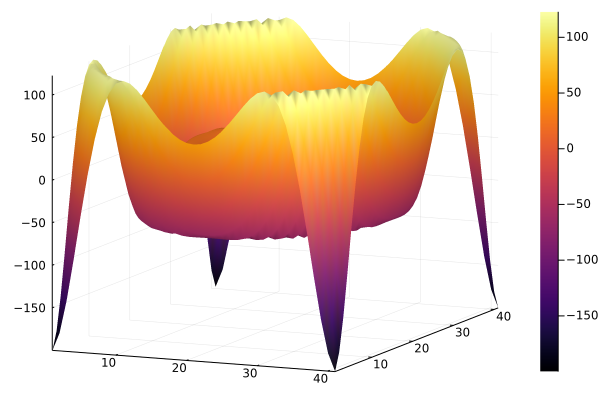

In [160]:
#新たに目標にする関数（ポテンシャルエネルギー）：Uが更新されているので注意
U(θ)=sin(norm(θ))*norm(θ)^2

#求めたい分布の形状の描画
B = [ -sin(sqrt(x^2+y^2))*(x^2+y^2) for x in -10.0:0.5:10.0, y in -10.0:0.5:10.0]
surface(B)

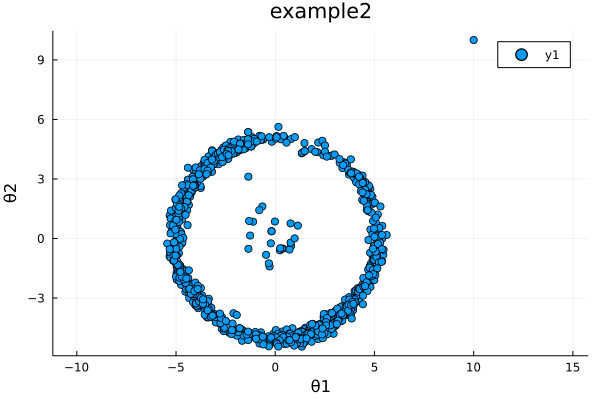

In [168]:
#サンプリングして、描画してみる
test2=HMC(100,1000,10,0.1,[10.0,10.0])
example2=scatter([(test2[1][i][1],test2[1][i][2]) for i in 1:1000],
aspect_ratio=1.0,
xlabel="θ1",ylabel="θ2",title="example2")


In [167]:
#受容回数
test2[2]

980

# 考察
実際の分布関数は、任意の位置に対して正の値を返すので、上の分布はその意味で不適当であり、再現できていない。

（再現できるのであれば、輪が何重かにかかっているはずである）

その意味で、真似したい分布関数がその条件を満たすのであれば、効率的なサンプリングが可能である。